In [1]:
# Some standard libraries
import numpy as np
import matplotlib.pyplot as plt
from qutip import fock, Qobj

# Libraries for creating, running and visualizing quantum circuits 
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer
from qiskit.circuit import Parameter
from qiskit.compiler import transpile
from qiskit.tools.visualization import plot_histogram
from IPython.display import display, Math, clear_output

# Libraries for using Quantum Inspire
from quantuminspire.credentials import get_authentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.qiskit import QI
from os import getenv
QI_URL = getenv('API_URL', 'https://api.quantum-inspire.com/')

%run CircuitTesting.ipynb

<span style='color:yellow'> **Run on quantum inspire instead** </span>

In [2]:
backend = BasicAer.get_backend('qasm_simulator')

## Circuit

<IPython.core.display.Math object>

<IPython.core.display.Math object>

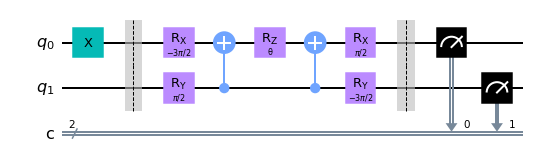

In [4]:
# Initialsiation of circuit
n = 2                        # number of qubits
q = QuantumRegister(n,'q')   # quantum register of n qubits
c = ClassicalRegister(n,'c') # classical register of 1 bit
qc = QuantumCircuit(q,c)     # quantum circuit on register

theta = Parameter('θ') # create a variable for the z-rotation gate

# Gates
def circuit(qc,q):
    qc.x(q[0])             # initialise in |01>
    qc.barrier(q)
    
    qc.rx(-3*np.pi/2,q[0]) #-X(pi/2) gate
    qc.ry(np.pi/2,q[1])    # Y(pi/2) gate
    qc.cnot(q[1],q[0])     # CNOT 1->0
    qc.rz(theta,q[0])      # Z(theta) gate with theta suggested by classical optimizer
    qc.cnot(q[1],q[0])     # CNOT 1->0
    qc.ry(-3*np.pi/2,q[1]) #-Y(pi/2) gate
    qc.rx(np.pi/2,q[0])    # X(pi/2) gate
    qc.barrier(q)
    
# Apply gates to circuit
circuit(qc,q)
'''Temporary way to get phase classically (simulation, not possible on quantum hardware!)'''
state_from_circuit(qc.bind_parameters({theta: np.pi/2}))
state_from_circuit(qc.bind_parameters({theta: 3*np.pi/2}))
qc.measure(q,c)

# Draw circuit using output method matplotlib
display(qc.draw(output='mpl'))

#### Run circuit with range of $\theta$'s

In [5]:
number_of_theta_points = 100
theta_range = np.linspace(0,2*np.pi,number_of_theta_points)
circuits = [qc.bind_parameters({theta: theta_val}) for theta_val in theta_range]

job = backend.run(transpile(circuits, backend))
counts = job.result().get_counts()

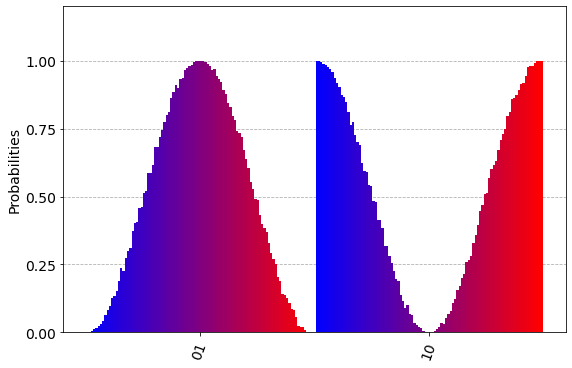

In [6]:
R = np.linspace(0,1,number_of_theta_points)
G = np.zeros(number_of_theta_points)
B = np.linspace(1,0,number_of_theta_points)
cmap = [(r,g,b) for r,g,b in zip(R,G,B)]

fig = plot_histogram(counts,figsize=(9,6),color=cmap,bar_labels=False)
fig.patch.set_facecolor('white')
display(fig)

## Hamiltonian using Qiskit (PyQuante2 driver)

#### Import modules

- `Molecule`: used to create a molecule instance storing all relevant data
- `ElectronicStructureDriverType`: used to specify the driver used in calculations
- `ElectronicStructureMoleculeDriver`: Molecule based electronic structure driver
- `ElectronicStructureProblem`: generates electronic structure problem which we want to solve
- `QubitConverter`: converts hamiltonian from second-quantized to qubit (spin) operators
- `...Mapper`: used by `QubitConverter` to map fermionic operators to qubit operators

- `settings.dict_aux_operators=True` sets `ElectronicStructureProblem` output to dict instead of list

In [7]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)

from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature import settings
settings.dict_aux_operators = True

#### Create molecule and driver

The geometry of the hydrogen molecule is given as a linear array of 2 hydrogen atoms with a spacing on the z-axis of $0.7414$ Å ($=7.414\cdot10^{-12}$ m). Hydrogen molecules are electrically neutral, so charge $Q=0$ C. Spin multiplicity is defined as $2S+1$, here we assume the singlet state with $S=0$*.

In [8]:
R = 0.7414 # internuclear spacing we want to vary later, for now fixed

molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, R]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYQUANTE
)

###### The spin of a Hydrogen molecule consists of the nuclear spins of both protons ($s=1/2$). The electron spins cancle because they need to be opposite to create a covalent bond between the two atoms. The nuclear spins can be either aligned, forming a triplet state called orthohydrogen with $S=1$, or anti-aligned, forming a singlet state called parahydrogen with $S=0$. At room temperature hydrogen consists for about 25% of parahydrogen. parahydrogen is in a lower energy state than orthohydrogen and since we are searching for the ground state, we use this $S=0$ state.

#### Create electronic structure problem and return second-quantized operators

In [9]:
es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()
print(second_q_op['ElectronicEnergy'])

Fermionic Operator
register length=4, number terms=14
  (0.18128881027902402+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.181288810279024+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.181288810279024+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.181288810279024+0j) * ( -_0 +_1 -_2 +_3 )
+ (- ...


#### Convert second-quantized to spin/qubit operators using Jordan Wigner transformation

#### Convert second-quantized to spin/qubit operators using Bravyi-Kitaev transformation

#### Convert second-quantized to spin/qubit operators using Parity mapper, which uses known symmetries to reduce the problem to 2 qubits

In [10]:
qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
qubit_op = qubit_converter.convert(second_q_op['ElectronicEnergy'], num_particles=es_problem.num_particles)
print(qubit_op)

-1.0537076260718947 * II
+ (-0.39398369592323595-1.3877787807814457e-17j) * ZI
+ (0.3939836959232358-4.163336342344337e-17j) * IZ
- 0.011236587537901799 * ZZ
+ 0.18128881027902394 * XX


<span style='color:yellow'> **Should be real values, however, the imaginary parts are an order $10^{17}$ smaller than the real parts. We thus can assume these are artifacts from imperfect numerical calculations** </span>

In [42]:
Hamiltonian = dict(qubit_op.primitive.to_list())
Hamiltonian

{'II': (-1.0537076260718947+0j),
 'ZI': (-0.39398369592323595-1.3877787807814457e-17j),
 'IZ': (0.3939836959232358-4.163336342344337e-17j),
 'ZZ': (-0.011236587537901799+0j),
 'XX': (0.18128881027902394+0j)}

## Expectation values $\langle H(\theta) \rangle$

In [12]:
def state_from_counts(counts,number_of_qubits=2):
    """Returns a state estimate without phase consideration using measurment counts"""
    state = 0
    
    N = 2**number_of_qubits
    for i in range(0,N):
        try:
            state += np.sqrt(counts[format(i, f"0{number_of_qubits}b")]) * fock(N,i)
        except:
            pass
    
    return state.unit()
        
states = [state_from_counts(count) for count in counts]

#### $\langle ZI \rangle$, $\langle IZ \rangle$, $\langle XX \rangle$, $\langle YY \rangle$, $\langle ZZ \rangle$

In [52]:
X = Qobj([[0,1],[1,0]])
Y = Qobj([[0,-1j],[1j,0]])
Z = Qobj([[1,0],[0,-1]])
I = Qobj([[1,0],[0,1]])

def expct(state,operator):
    """Calculate expectation value of `operator` for a system in `state`"""
    return float(np.real(state.dag()*operator*state))

expectation_values = {'ZI':np.zeros(number_of_theta_points), 
                      'IZ':np.zeros(number_of_theta_points),
                      'XX':np.zeros(number_of_theta_points),
                      'YY':np.zeros(number_of_theta_points),
                      'ZZ':np.zeros(number_of_theta_points),
                      'II':np.ones(number_of_theta_points),
                      'H':0}
for i,state in enumerate(states):
    expectation_values['IZ'][i] = expct(state,np.kron(I,Z))
    expectation_values['ZI'][i] = expct(state,np.kron(Z,I))
    expectation_values['XX'][i] = expct(state,np.kron(X,X))
    expectation_values['YY'][i] = expct(state,np.kron(Y,Y))
    expectation_values['ZZ'][i] = expct(state,np.kron(Z,Z))
    
"""Temporary manual correction for phase"""
expectation_values['XX'][:number_of_theta_points//2] = -expectation_values['XX'][:number_of_theta_points//2]
expectation_values['YY'][:number_of_theta_points//2] = -expectation_values['YY'][:number_of_theta_points//2]

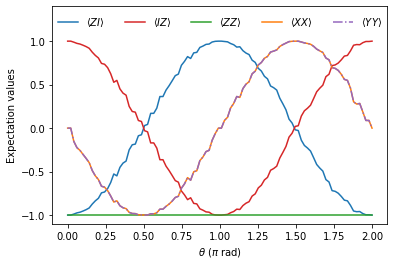

In [49]:
plt.figure()
plt.xlabel(r'$\theta$ ($\pi$ rad)')
plt.ylabel('Expectation values')
plt.plot(theta_range/np.pi,expectation_values['ZI'],label=r'$\langle ZI \rangle$',c='C0')
plt.plot(theta_range/np.pi,expectation_values['IZ'],label=r'$\langle IZ \rangle$',c='C3')
plt.plot(theta_range/np.pi,expectation_values['ZZ'],label=r'$\langle ZZ \rangle$',c='C2')
plt.plot(theta_range/np.pi,expectation_values['XX'],label=r'$\langle XX \rangle$',c='C1')
plt.plot(theta_range/np.pi,expectation_values['YY'],label=r'$\langle YY \rangle$',c='C4',ls='-.')
plt.ylim(-1.1,1.4)
plt.legend(loc='upper center',ncol=5,frameon=False)
plt.show()

#### $\langle H \rangle$

In [54]:
for key in expectation_values:
    try:
        expectation_values['H'] += Hamiltonian[key]*expectation_values[key]
    except:
        pass

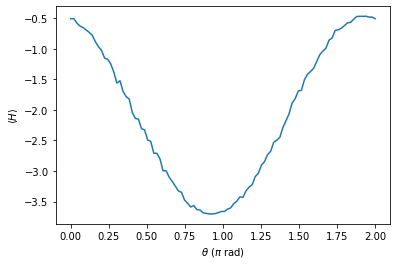

In [ ]:
plt.figure()
plt.xlabel(r'$\theta$ ($\pi$ rad)')
plt.ylabel(r'$\langle H \rangle$')
plt.plot(theta_range/np.pi,np.real(expectation_values['H']))
plt.show()

## Expectation values $\langle H(\theta,R) \rangle$

In [79]:
from functools import partial
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.algorithms.pes_samplers import BOPESSampler

#### Principles

In [ ]:
stretch1 = partial(Molecule.absolute_stretching, atom_pair=(1, 0))
molecule = Molecule(
    geometry=[("H", [0.0, 0.0, 0.0]), ("H", [0.0, 0.0, 0.4])],
    degrees_of_freedom=[stretch1]
)

driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYQUANTE
)

In [67]:
molecule.perturbations = [0.2]
print(molecule.geometry)

molecule.perturbations = [0.6]
print(molecule.geometry)

molecule.perturbations = [0.0]
print(molecule.geometry)

[('H', [0.0, 0.0, 0.0]), ('H', [0.0, 0.0, 0.6000000000000001])]
[('H', [0.0, 0.0, 0.0]), ('H', [0.0, 0.0, 1.0])]
[('H', [0.0, 0.0, 0.0]), ('H', [0.0, 0.0, 0.4])]


#### Sampler (exact copy of [qiskit-nature tutorials](https://qiskit.org/documentation/nature/tutorials/05_Sampling_potential_energy_surfaces.html))

In [76]:
qubit_converter = QubitConverter(JordanWignerMapper())
quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))
solver = VQE(quantum_instance=quantum_instance)

me_gsc = GroundStateEigensolver(qubit_converter, solver)

In [84]:
distance1 = partial(Molecule.absolute_distance, atom_pair=(1, 0))
molecule = Molecule(
    geometry=[("H", [0.0, 0.0, 0.0]), ("H", [0.0, 0.0, 0.3])],
    degrees_of_freedom=[distance1],
)

# pass molecule to PyQuante2 driver
driver = ElectronicStructureMoleculeDriver(molecule, driver_type=ElectronicStructureDriverType.PYQUANTE)

es_problem = ElectronicStructureProblem(driver)


# Specify degree of freedom (points of interest)
points = np.linspace(0.4, 3, 30)
results_full = {}  # full dictionary of results for each condition
results = {}  # dictionary of (point,energy) results for each condition
conditions = {False: "no bootstrapping", True: "bootstrapping"}

In [88]:
for value, bootstrap in conditions.items():
    # define instance to sampler
    bs = BOPESSampler(gss=me_gsc, bootstrap=value, num_bootstrap=None, extrapolator=None)
    
    # execute
    res = bs.sample(es_problem, points)
    
    results_full[f"{bootstrap}"] = res.raw_results
    results[f"points_{bootstrap}"] = res.points
    results[f"energies_{bootstrap}"] = res.energies


In [90]:
# define numpy solver
solver_numpy = NumPyMinimumEigensolver()
me_gsc_numpy = GroundStateEigensolver(qubit_converter, solver_numpy)
bs_classical = BOPESSampler(
    gss=me_gsc_numpy, bootstrap=False, num_bootstrap=None, extrapolator=None
)
# execute
res_np = bs_classical.sample(es_problem, points)
results_full["np"] = res_np.raw_results
results["points_np"] = res_np.points
results["energies_np"] = res_np.energies

Text(0, 0.5, 'Energy')

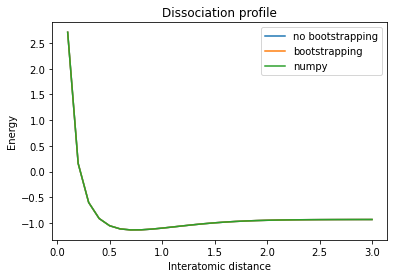

In [91]:
fig = plt.figure()
for value, bootstrap in conditions.items():
    plt.plot(results[f"points_{bootstrap}"], results[f"energies_{bootstrap}"], label=f"{bootstrap}")
plt.plot(results["points_np"], results["energies_np"], label="numpy")
plt.legend()
plt.title("Dissociation profile")
plt.xlabel("Interatomic distance")
plt.ylabel("Energy")

## Ground state solver using VQE (exact copy of [qiskit-nature tutorials](https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html), idk what it does or how yet)

#### Initialise VQE

In [14]:
from qiskit.providers.aer import StatevectorSimulator
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory

quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))
vqe_solver = VQEUCCFactory(quantum_instance)

#### Define VQE

In [15]:
from qiskit.algorithms import VQE
from qiskit.circuit.library import TwoLocal

tl_circuit = TwoLocal(
    rotation_blocks=["h", "rx"],
    entanglement_blocks="cz",
    entanglement="full",
    reps=2,
    parameter_prefix="y",
)

another_solver = VQE(
    ansatz=tl_circuit,
    quantum_instance=QuantumInstance(Aer.get_backend("aer_simulator_statevector")),
)

#### Run calculation

In [16]:
from qiskit_nature.algorithms import GroundStateEigensolver

calc = GroundStateEigensolver(qubit_converter, vqe_solver)
res = calc.solve(es_problem)

print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.851024217522
  - computed part:      -1.851024217522
~ Nuclear repulsion energy (Hartree): 0.71375404505
> Total ground state energy (Hartree): -1.137270172472
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000


#### Compare exact result with VQE

The NumPy minimum eigensolver: this algorithm **exactly** diagonalizes the Hamiltonian. Although it scales badly, it can be used on small systems to check the results of the quantum algorithms.

In [17]:
from qiskit.algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
calc = GroundStateEigensolver(qubit_converter, numpy_solver)
res = calc.solve(es_problem)

In [18]:
print(f'{res.computed_energies[0]} Ha = {res.computed_energies[0]*27.21138624599} eV')

-1.8510242175801919 Ha = -50.368934935256036 eV
